In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN



pd.options.display.float_format = '{:,.2f}'.format


%matplotlib inline

# Prepare data

In [2]:
from ngc_claims_functions import  *


# Read Generali data
train, test, target = read_generali_data()

# Merge under represented categories
train = merge_generali_data(train)
test = merge_generali_data(test) 

#Define categ_col_list
categ_col_list = [col for col in train.columns if 'categ' in col]
categ_col_list.remove("ft_22_categ")
train_ft_2_categ = train["ft_2_categ"]
test_ft_2_categ = test["ft_2_categ"]

# Tranform to dummies
train_dummies, test_dummies = dummies(train, test , columns = categ_col_list)

#############################################################
# Filter out rows without Insee data
# All the following analyze will be build thanks to area data
train_dummies = train_dummies[with_Insee_mask(train)]
train_dummies.reset_index(inplace=True)

target = target[with_Insee_mask(train)]
target.reset_index(inplace=True)
train_ft_2_categ = train_ft_2_categ[with_Insee_mask(train)]
train_ft_2_categ = train_ft_2_categ.reset_index()

test_dummies = test_dummies[with_Insee_mask(test)]
test_dummies.reset_index(inplace=True)
test_ft_2_categ = test_ft_2_categ[with_Insee_mask(test)]
test_ft_2_categ = test_ft_2_categ.reset_index()

# Save some initial data for variable creation 
insee_train = train_dummies["Insee"].copy()
insee_test = test_dummies["Insee"].copy()
del  train_dummies["Insee"]
del  test_dummies["Insee"]

# Impute NaN
train_dummies,knn_22, knn_superficie = impute_categ_knn(train_dummies, 5)
test_dummies = impute_categ_knn(test_dummies, 0, knn_superficie, knn_22)

train_dummies = pd.concat( (train_dummies, insee_train ) , axis=1)
test_dummies = pd.concat( (test_dummies, insee_test ) , axis=1)

# Create some features to help model
train_dummies = create_features(train_dummies, train)
test_dummies = create_features(test_dummies, test)

# Read commune data 
commune_df_dummies = read_commune_social_data()

# So we can join dataframes together directly
train_complete_df = train_dummies.merge(commune_df_dummies, how='left', left_on='Insee', right_on='CODGEO')
test_complete_df = test_dummies.merge(commune_df_dummies, how='left', left_on='Insee', right_on='CODGEO')

# Impute Commune NaN data
train_complete_df, knn_class_list, knn_class_codgeo, knn_reg_list = impute_commune_NaN(train_complete_df, n_knn=3)
test_complete_df = impute_commune_NaN(test_complete_df, 0, knn_class_list, knn_class_codgeo, knn_reg_list)


WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
Orientation Economique_BassinIndustriel
Orientation Economique_BassinRésidentiel
Orientation Economique_BassinUrbain
Orientation Economique_Bassindiversifié
Orientation Economique_BassinsAgroalimentaire
Urbanité Ruralité_Comrurale<2000mhabts
Urbanité Ruralité_Com<50mhabts
Urbanité Ruralité_Comrurale>2000habts
Urbanité Ruralité_Com<10mhabts
Urbanité Ruralité_Com<200mhabts
Urbanité Ruralité_Com>200mhabts
Orientation Economique_BassinIndustriel
Orientation Economique_BassinRésidentiel
Orientation Economique_BassinUrbain
Orientation Economique_Bassindiversifié
Orientation Economique_BassinsAgroalimentaire
Urbanité Ruralité_Comrurale<2000mhabts
Urbanité Ruralité_Com<50mhabts
Urbanité Ruralité_Comrurale>2000habts
Urbanité Ruralité_Com<10mhabts
Urbanité Ruralité_Com<200mhabts
Urbanité Ruralité_Com>200mhabts


In [3]:

# And create some interactions between features
train_complete_df = create_commune_data(train_complete_df)
test_complete_df = create_commune_data(test_complete_df)

# Add data from ONRN 
train_complete_df = add_ONRN_data(train_complete_df)
test_complete_df = add_ONRN_data(test_complete_df)

# Clean dataframes with useless cols for the models
train_complete_df, CODGEO, NOM_COM, Num_Dep = clean_cols(train_complete_df)
test_complete_df, CODGEO, NOM_COM, Num_Dep = clean_cols(test_complete_df)

# Rename cols
train_complete_df = rename_df_cols(train_complete_df)
test_complete_df = rename_df_cols(test_complete_df)



###########################################################################
# Use mean encoding to create features
# 
# Create Dept_Year interaction before encoding mean and Insee mean encoding
train_complete_df["target"] = target["target"]

train_complete_df['Dept_Year'] = insee_train.str[:2]+ train_ft_2_categ.ft_2_categ.astype(str)
test_complete_df['Dept_Year'] = insee_test.str[:2]+ test_ft_2_categ.ft_2_categ.astype(str)
train_complete_df, test_complete_df = encode_col_mean(train_complete_df, test_complete_df, 'Dept_Year')

# Add a mean encoding feature on Insee
train_complete_df['Insee'] = insee_train
test_complete_df['Insee'] = insee_test
train_complete_df, test_complete_df = encode_col_mean(train_complete_df, test_complete_df, 'Insee')

# Binarize superficief and encode ponderated mean value on each bin
train_complete_df["superficief_bins"] = pd.cut(train_complete_df["superficief"], bins=100, labels=False)
test_complete_df["superficief_bins"] = pd.cut(test_complete_df["superficief"], bins=100, labels=False)
train_complete_df, test_complete_df = encode_col_mean(train_complete_df, test_complete_df, "superficief_bins")


# Build ponderated mean cols using concatention of 2 sets of category features  
# Use original data without any NaN
train_copy = train.copy()
test_copy = test.copy()
train_copy = train_copy[with_Insee_mask(train)]
train_copy.reset_index(inplace=True)
test_copy = test_copy[with_Insee_mask(test)]
test_copy.reset_index(inplace=True)

# First set of features to build ponderated mean on
train_categ_col_list_df = train_copy["ft_4_categ"].copy()
test_categ_col_list_df = test_copy["ft_4_categ"].copy()

# Concat categorical features values to create bucket values
for col in ['ft_4_categ', 'ft_5_categ', 'ft_6_categ', 'ft_7_categ', 'ft_8_categ', 
            'ft_9_categ', 'ft_10_categ', 'ft_11_categ', 'ft_12_categ', 'ft_13_categ',
             'ft_14_categ', 'ft_15_categ', 'ft_16_categ', 'ft_17_categ' ]:
    train_categ_col_list_df = train_categ_col_list_df.astype(str).str[:] + train_copy[col].astype(str).str[:]
    test_categ_col_list_df = test_categ_col_list_df.astype(str).str[:] + test_copy[col].astype(str).str[:]

# Then evaluate ponderated mean on each buckets
train_complete_df["categ_col_list_1"] = train_categ_col_list_df
test_complete_df["categ_col_list_1"] = test_categ_col_list_df
train_complete_df, test_complete_df = encode_col_mean(train_complete_df, test_complete_df, "categ_col_list_1")
    
# Second set here
train_categ_col_list_df = train_copy["ft_18_categ"].copy()
test_categ_col_list_df = test_copy["ft_18_categ"].copy()
# Concat categorical features values to create bucket values
for col in ['ft_19_categ', 'ft_21_categ' ]:
    train_categ_col_list_df = train_categ_col_list_df.astype(str).str[:] + train_copy[col].astype(str).str[:]
    test_categ_col_list_df = test_categ_col_list_df.astype(str).str[:] + test_copy[col].astype(str).str[:]

# Then evaluate ponderated mean on each buckets    
train_complete_df["categ_col_list_2"] = train_categ_col_list_df
test_complete_df["categ_col_list_2"] = test_categ_col_list_df
train_complete_df, test_complete_df = encode_col_mean(train_complete_df, test_complete_df, "categ_col_list_2")

# Clean features only used to build col means
del train_complete_df['target']

for col in ['Insee', 'Dept_Year', 'superficief_bins', 'categ_col_list_1', 'categ_col_list_2']:
    del train_complete_df[col]
    del test_complete_df[col]


In [4]:
train_complete_df.to_csv("./train_complete_df.csv")
test_complete_df.to_csv("./test_complete_df.csv")
target.to_csv("./target.csv")

In [5]:
train_complete_df  = pd.read_csv("./train_complete_df.csv")
test_complete_df = pd.read_csv("./test_complete_df.csv")
target = pd.read_csv("./target.csv")

del train_complete_df["Unnamed: 0"]
del test_complete_df["Unnamed: 0"]
del target["Unnamed: 0"]

## Identify Outliers

In [6]:
#Combine train and test datasets 
combined_df = train_complete_df.append(test_complete_df, sort=True)
combined_df.reset_index(inplace=True)
combined_df.drop('index', inplace=True, axis=1)

#Look at the combine row number
max_idx_train = train_complete_df.shape[0]


In [7]:
from sklearn.cluster import DBSCAN

#Identify outliers by looking at noise just before switching from only one cluster to 2
n_epss = list()
n_noise_s = list()
n_clusters_s = list()

for n_eps in np.arange(35000,60000,500): 
    db = DBSCAN(eps=n_eps, min_samples=5, n_jobs=-1).fit(combined_df)
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    n_epss.append(n_eps)
    print("neps : "+ str(n_eps))
    n_clusters_s.append(n_clusters_)
    print("nclusters : " + str(n_clusters_))
    n_noise_s.append(n_noise_)
    print("noise : "+str(n_noise_))
    
    # Number of test element in the noise
    noise_idx_list = [i for i,x in enumerate(list(labels)) if x==-1]
    nb_test_in_the_noise = len([i for i in noise_idx_list if i >= max_idx_train])
    print("Nb test in the noise : "+str(nb_test_in_the_noise))
    

neps : 35000
nclusters : 16
noise : 33
Nb test in the noise : 8
neps : 35500
nclusters : 16
noise : 29
Nb test in the noise : 6
neps : 36000
nclusters : 15
noise : 26
Nb test in the noise : 6
neps : 36500
nclusters : 14
noise : 26
Nb test in the noise : 6
neps : 37000
nclusters : 12
noise : 26
Nb test in the noise : 6
neps : 37500
nclusters : 12
noise : 23
Nb test in the noise : 6
neps : 38000
nclusters : 10
noise : 23
Nb test in the noise : 6
neps : 38500
nclusters : 10
noise : 23
Nb test in the noise : 6
neps : 39000
nclusters : 10
noise : 23
Nb test in the noise : 6
neps : 39500
nclusters : 9
noise : 23
Nb test in the noise : 6
neps : 40000
nclusters : 9
noise : 23
Nb test in the noise : 6
neps : 40500
nclusters : 9
noise : 22
Nb test in the noise : 6
neps : 41000
nclusters : 9
noise : 22
Nb test in the noise : 6
neps : 41500
nclusters : 9
noise : 22
Nb test in the noise : 6
neps : 42000
nclusters : 9
noise : 18
Nb test in the noise : 5
neps : 42500
nclusters : 8
noise : 17
Nb test 

Text(0.5, 1.0, 'n_clusters per eps = 35000+X*500')

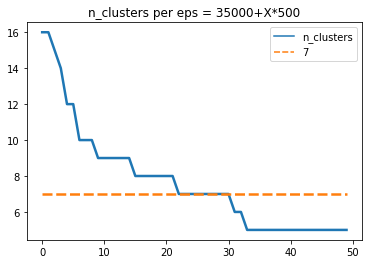

In [8]:
# Plot clusters per eps
dbscan_df = pd.DataFrame({"eps":n_epss, 
                          "n_clusters" : n_clusters_s, "n_noise" : n_noise_s})
dbscan_df["7"]=7
dbscan_df["10"]=10
sns.lineplot(data=dbscan_df.loc[:,["n_clusters","7"]], palette="tab10", linewidth=2.5).set_title("n_clusters per eps = 35000+X*500")


Text(0.5, 1.0, 'n_noise per eps = 35000+x*500')

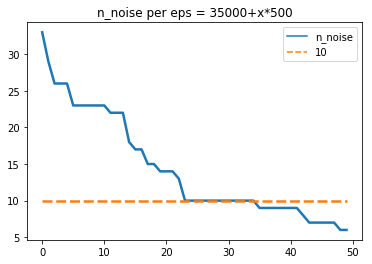

In [9]:
sns.lineplot(data=dbscan_df.loc[:,["n_noise","10"]], palette="tab10", linewidth=2.5
            ).set_title('n_noise per eps = 35000+x*500')


After <b><font color='blue'>neps over 46500</font></b>, there is 2 test rows in the noise and 8 train rows that do not fit any of the 7 clusters.<br>
This is the first very long step where the points in the noise stay stable. This configuration has a cluster number stable for a long. <br>
We imagine so that the noise represents very far points as all the points are already far from each others.<br>
As this density was already identified in the data exploration with only train dataset as input of the DBScan, we will choose this <b><font color='blue'>threshold</font></b> to remove noise for modeling.<br>


## Outliers management

In [10]:
# TO DO define the new threshold for combined dataframes

# 2 methods to remove outliers looking only at train data or including test data
outliers_threshold = 46500
outliers_with_test = True
if outliers_with_test :
    #outliers_idx = remove_combined_outliers(train_complete_df.select_dtypes(exclude=[object]), test_complete_df.select_dtypes(exclude=[object]), outliers_threshold)
    outliers_idx, train_complete_df, test_complete_df = remove_combined_outliers(train_complete_df, test_complete_df, target, outliers_threshold)
    
else:
    outliers_idx = remove_outliers(train_complete_df)
outliers_idx

C:\Users\query\Anaconda3_New\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


[174, 507, 2354, 3205, 5055, 5236, 6045, 7348]

## Add some features

In [11]:
index = train_complete_df["index"]
del train_complete_df["index"]
test_index = test_complete_df["index"]
del test_complete_df["index"]

In [12]:
## Apply Exposure and superficief factors on features
from sklearn.preprocessing import MinMaxScaler

# Create cumulated risk features
#        interaction with EXPOsure time
def set_product_features(df):    

    ## Build features from all risks collected 
    all_risks = ['Freq_TGN_1987_2015',
     'Nb_reco_CatNat_inon',
     'Nb_reco_CatNat_sech',
     'Nb_reco_CatNat_MVT',
     'Freq_moy_inon_Entre0et1‰',
     'Freq_moy_inon_0',
     'Freq_moy_inon_Entre2et5‰',
     'Freq_moy_inon_Entre5et10‰',
     'Freq_moy_inon_Plusde10‰',
     'Freq_moy_inon_Entre1et2‰',
     'Freq_moy_sech_Entre0et1‰',
     'Freq_moy_sech_0',
     'Freq_moy_sech_Entre1et2‰',
     'Freq_moy_sech_Entre2et5‰',
     'Freq_moy_sech_Entre5et10‰',
     'Freq_moy_sech_Plusde10‰',
     'Freq_moy_sei_0',
     'Freq_moy_sei_Entre0et1‰',
     'Freq_moy_sei_Entre1et2‰',
     'Freq_moy_sei_Plusde10‰',
     'Freq_moy_sei_Entre5et10‰',
     'Freq_moy_sei_Entre2et5‰',
     'Freq_moy_MVT_0',
     'Freq_moy_MVT_Entre0et1‰',
     'Freq_moy_MVT_Entre1et2‰',
     'Freq_moy_MVT_Entre2et5‰']


    #Xtrain = df.copy()
    #train_targets = target["target"].copy()
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_data = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

    # Gather a risk feature 
    all_risks = df_data[all_risks].sum(axis=1)
    all_risks_expo = all_risks * df["EXPO"]
    all_risks_superficief = all_risks * df["superficief"]
    
    # 
    tmp_df = pd.DataFrame({"all_risks" : all_risks, 
                       "all_risks_expo" : all_risks_expo,
                        "all_risks_superficief" : all_risks_superficief})

    df = pd.concat((df,tmp_df), axis=1)
    df['Nb_reco_total'] = df[['Nb_reco_CatNat_inon', 'Nb_reco_CatNat_sech', 'Nb_reco_CatNat_MVT']].sum(axis=1)
    df['Nb_reco_total_EXPO'] = df["EXPO"] * df[['Nb_reco_CatNat_inon', 'Nb_reco_CatNat_sech', 'Nb_reco_CatNat_MVT']].sum(axis=1)
    
    # Add a expo * superficief variable
    df["superficief_expo"] = df["superficief"] * df["EXPO"] 
    df["superficief_REG"] = df["superficief"] * df["REG"]
    df["superficief_Bloc"] = df["superficief"] * df["Bloc"]
    df["EXPO_REG"] = df["EXPO"] * df["REG"]
    df["EXPO_Bloc"] = df["EXPO"] * df["Bloc"]
    
    # Add polynomial variable
    df["EXPO^2"] = df["EXPO"] * df["EXPO"]
    df["superficief^2"] = df["superficief"] * df["superficief"]
    
    #df["superficief_expo_Age"] = df["superficief"] * df["EXPO"] * df["Age"] 
    
    
    return df

train_complete_df = set_product_features(train_complete_df)
test_complete_df = set_product_features(test_complete_df)
    

C:\Users\query\Anaconda3_New\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\query\Anaconda3_New\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
ft_expo_categ_list = [col for col in train_complete_df.columns if '_categ_' in col]
for col in ft_expo_categ_list:
    train_complete_df['EXPO_'+col] = train_complete_df['EXPO'] * train_complete_df[col]
    test_complete_df['EXPO_'+col] = test_complete_df['EXPO'] * test_complete_df[col]

    

# Build Model

## Train a XGBoost Classifier model

### Select features for XGBoost Classifier

In [14]:
import xgboost as xgb
from sklearn import metrics

# Get feature importance for XGBoost with a xgb default setting
target_s = target.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
xgb_clf1 = xgb.XGBClassifier().fit(train_complete_df, target_s)

xgb_feature_importances = pd.DataFrame(xgb_clf1.feature_importances_, index = train_complete_df.columns, columns=['importance']).sort_values('importance', ascending=False)
ordered_cols_by_importance = list(xgb_feature_importances.index)

# Then go forward removing features correlated over corr_threshold
# Get correlation
corr = train_complete_df[ordered_cols_by_importance].corr()

# Step forward filtering out features with more than a given threshold correlation 
corr_threshold = 0.5
columns_mask = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= corr_threshold:
            if columns_mask[j]:
                columns_mask[j] = False

auto_selected_cols = train_complete_df[ordered_cols_by_importance].columns[columns_mask]

In [15]:
# A score keep all the features
import xgboost as xgb
from sklearn import metrics

xgb_clf1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=9999999999,
       n_estimators=1000, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.4)

double_split_train_test(xgb_clf1, train_complete_df[auto_selected_cols], target, outliers_idx, nb_CV = 5,  print_scores=True, print_feature_bool=False)

Train mean score: 0.5275665226663706
Test mean score : 0.44577423224869667
STD Test score: 0.031901765957640583
External Test score : 0.42048420234327283


(0.031901765957640583,
 0.5275665226663706,
 0.44577423224869667,
 0.42048420234327283,
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
        max_depth=2, min_child_weight=1, missing=9999999999,
        n_estimators=1000, n_jobs=-1, nthread=None,
        objective='binary:logistic', random_state=0, reg_alpha=0.01,
        reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
        subsample=0.4),
                                                importance
 superficief_expo                                     0.05
 EXPO_ft_21_categ_4                                   0.04
 EXPO_ft_7_categ_2                                    0.03
 superficief_Bloc                                     0.02
 ft_24_categ__SUP_=8                                  0.02
 EXPO_ft_19_categ_2                                   0.02
 EXPO_ft_24_categ_7                                   0.02
 EXPO_ft_21_categ_1  

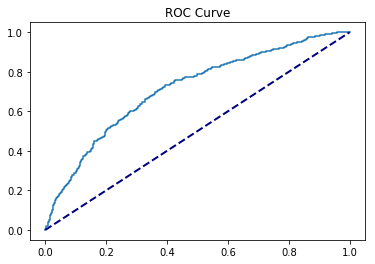

Confusion matrix, without normalization
[[1494   72]
 [ 379   81]]


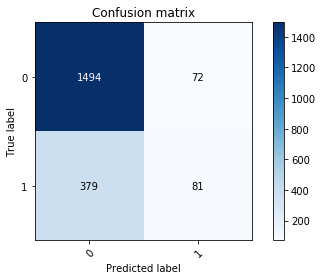

0.4256566161363763

In [16]:
# First XGBClassifier 
import xgboost as xgb
from sklearn import metrics


def first_xgb(train_dummies, target):
    ##########################
    ## Part 1 : External Split
    ##########################
    nb_CV = 5
    CV = cross_validation_split(train_dummies, target, folds=nb_CV, target_signed=False) 
    
    # Internal CV evaluation
    cv_train_idx = list()
    cv_test_idx = list()
    train_score = list()
    test_score = list()
    
    # define train & test index
    cv_train_idx.append([ CV[x].index for x in range(nb_CV-1)])
    
    X_train = train_complete_df[train_complete_df.index.isin([val for sublist in cv_train_idx[0] for val in sublist])]
    y_train = target[target.index.isin([val for sublist in cv_train_idx[0] for val in sublist])]
    
    # Build the test dataset on a folder 
    cv_test_idx = CV[nb_CV-1].index
    X_test = train_complete_df[train_complete_df.index.isin(cv_test_idx)]
    y_test = target[target.index.isin(cv_test_idx)] 
    
    y_train_s = y_train.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    y_test_s = y_test.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    
    xgb_clf1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=9999999999,
       n_estimators=600, n_jobs=-1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.01,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.4)

    xgb_clf1.fit(X_train, y_train_s)
    xgb_clf_pred_proba = xgb_clf1.predict_proba(X_test)[:, 1]
    
    # Display ROC Curve
    fpr, tpr, _ = metrics.roc_curve(y_test_s, xgb_clf_pred_proba)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC Curve")
    plt.show()
    
    # Display confusion matrix
    analyze_model(xgb_clf_pred_proba, y_test.target)
    
    return xgb_clf1, gini_normalized(y_test_s, xgb_clf_pred_proba)

xgb_clf1, gini_score = first_xgb(train_complete_df[auto_selected_cols], target)
gini_score

### Keep feature only if it increase the model performance

In [17]:
# For various features number took among the feature importance list produced with "auto_selected_cols", 
# fit and evaluate models performances
nb_feat_mean_train_scores = list()
nb_feat_mean_test_scores=list()
nb_feat_ext_test_scores = list()
x_values = range(3,len(ordered_cols_by_importance))

list_var=list()
final_feature_list=list()
final_feature_list.append( list(xgb_feature_importances[0:2].index)[0] )
final_feature_list.append( list(xgb_feature_importances[0:2].index)[1] )

prev_mean_test = 0
for i in x_values:
    # Define the current set of features to test
    feature_to_test = list(xgb_feature_importances[:i+1].index)[i]    
    list_var = final_feature_list.copy()
    list_var.append(feature_to_test)
    
    # Train and get scores
    std, mean_train, mean_test, ext_test_score, xgb_trained, xgb_feat_imp = double_split_train_test(xgb_clf1, train_complete_df[list_var], target, outliers_idx, nb_CV = 4, print_scores=True)
    
    # If the ci=urrent feature improve the mean test result add the feature into the final list
    if prev_mean_test <= mean_test:
        nb_feat_mean_train_scores.append(mean_train)
        nb_feat_mean_test_scores.append(mean_test)
        nb_feat_ext_test_scores.append(ext_test_score)
        prev_mean_test = mean_test
        final_feature_list.append(list(xgb_feature_importances[0:i+1].index)[i])
    
    
    

Train mean score: 0.46007096113300394
Test mean score : 0.4240027301914343
STD Test score: 0.0336255984313549
External Test score : 0.40779005893472703
Train mean score: 0.45980755185676503
Test mean score : 0.4256490185326063
STD Test score: 0.03243480041445483
External Test score : 0.40740042255087294
Train mean score: 0.4712285278170466
Test mean score : 0.43228937601778117
STD Test score: 0.03512261186270547
External Test score : 0.41402957856110306
Train mean score: 0.4741141022692068
Test mean score : 0.4325635668919287
STD Test score: 0.03410046854250156
External Test score : 0.41492627599243853
Train mean score: 0.4739455151887212
Test mean score : 0.43304647939984353
STD Test score: 0.032703992263351175
External Test score : 0.4148017346825309
Train mean score: 0.4764926293757663
Test mean score : 0.4328232376344021
STD Test score: 0.0332040316855595
External Test score : 0.4180807294562437
Train mean score: 0.47547126392018185
Test mean score : 0.43329529630923036
STD Test sc

Train mean score: 0.49403801904520445
Test mean score : 0.44181662572708663
STD Test score: 0.029554822140618938
External Test score : 0.42499455131769154
Train mean score: 0.4913289271500415
Test mean score : 0.43927205128934355
STD Test score: 0.030310290419830827
External Test score : 0.4244394529078171
Train mean score: 0.49134947673181395
Test mean score : 0.4397644400750822
STD Test score: 0.030082929009353127
External Test score : 0.4248842433003447
Train mean score: 0.49308848573640535
Test mean score : 0.44014967921849335
STD Test score: 0.028555280413423794
External Test score : 0.4226371622372957
Train mean score: 0.49293439036946207
Test mean score : 0.44010857381570473
STD Test score: 0.030117767464788132
External Test score : 0.42634671411097513
Train mean score: 0.4929774781265115
Test mean score : 0.4414522346469622
STD Test score: 0.029439363502112997
External Test score : 0.42489313910819526
Train mean score: 0.4915416665511556
Test mean score : 0.43974847924957083
ST

Train mean score: 0.49885719799770345
Test mean score : 0.44718934653653214
STD Test score: 0.029520457526348833
External Test score : 0.42173690648282
Train mean score: 0.49901059266740555
Test mean score : 0.44719336381837527
STD Test score: 0.03015867598679451
External Test score : 0.42183298120760593
Train mean score: 0.49877533665571405
Test mean score : 0.4471291749046542
STD Test score: 0.029640302946199532
External Test score : 0.42173690648282
Train mean score: 0.4989066534072121
Test mean score : 0.447234320827508
STD Test score: 0.029667231924881268
External Test score : 0.42155009451795833
Train mean score: 0.49901705819051756
Test mean score : 0.447365379583652
STD Test score: 0.029354606259373712
External Test score : 0.42166751918158574
Train mean score: 0.49890837948346983
Test mean score : 0.44744542021078487
STD Test score: 0.029682981023866493
External Test score : 0.4219290559323918
Train mean score: 0.4990259261043431
Test mean score : 0.4471695306268944
STD Test s

Train mean score: 0.49890111536636195
Test mean score : 0.4476242988150385
STD Test score: 0.02982205591437104
External Test score : 0.4217137773824085
Train mean score: 0.4989229189825971
Test mean score : 0.44760686572640235
STD Test score: 0.029822910501101797
External Test score : 0.42171021905926837
Train mean score: 0.4988835318048819
Test mean score : 0.4476068657264023
STD Test score: 0.029856814892084728
External Test score : 0.421850772823307
Train mean score: 0.4989370076078976
Test mean score : 0.44754454807318694
STD Test score: 0.029848385457711152
External Test score : 0.42184187701545645
Train mean score: 0.4988206705725907
Test mean score : 0.4475569436998533
STD Test score: 0.029796537732402307
External Test score : 0.4219415100633826
Train mean score: 0.4989206386276812
Test mean score : 0.4476338284785679
STD Test score: 0.029861575020965783
External Test score : 0.42184187701545645
Train mean score: 0.4989168526538865
Test mean score : 0.44763856225119536
STD Test 

Train mean score: 0.5013310465874546
Test mean score : 0.44891451434323515
STD Test score: 0.030841999258501975
External Test score : 0.425759590792839
Train mean score: 0.5013606652814384
Test mean score : 0.44882079005050796
STD Test score: 0.0310176212379787
External Test score : 0.4259908817969532
Train mean score: 0.5013303376088242
Test mean score : 0.44888687306145303
STD Test score: 0.030851715956570998
External Test score : 0.42585210719448463
Train mean score: 0.5013310465874546
Test mean score : 0.44891451434323515
STD Test score: 0.030841999258501975
External Test score : 0.425759590792839
Train mean score: 0.5013665845958647
Test mean score : 0.4489022774632704
STD Test score: 0.03068133329978373
External Test score : 0.4258948070721673
Train mean score: 0.5013001671980784
Test mean score : 0.4490020283389566
STD Test score: 0.03084017331700183
External Test score : 0.4256314911597909
Train mean score: 0.5013310465874546
Test mean score : 0.44891451434323515
STD Test score

Train mean score: 0.5007054885036053
Test mean score : 0.4477920493355239
STD Test score: 0.03010648957599628
External Test score : 0.4239786500611587
Train mean score: 0.5005825705703184
Test mean score : 0.44789380128990697
STD Test score: 0.03012619505108678
External Test score : 0.4238630045591015
Train mean score: 0.5010180673911773
Test mean score : 0.44780670963843483
STD Test score: 0.030226547527907655
External Test score : 0.42449638607806084
Train mean score: 0.5007054885036053
Test mean score : 0.4477920493355239
STD Test score: 0.03010648957599628
External Test score : 0.4239786500611587
Train mean score: 0.5012364936469766
Test mean score : 0.44771056192276143
STD Test score: 0.02954980263678614
External Test score : 0.4234733681752475
Train mean score: 0.5005494255569285
Test mean score : 0.4478716137225518
STD Test score: 0.030098382689266977
External Test score : 0.4238630045591015
Train mean score: 0.5006468984358956
Test mean score : 0.44790528026690446
STD Test scor

Train mean score: 0.5005575139952094
Test mean score : 0.447907272312944
STD Test score: 0.030222298548833803
External Test score : 0.4239644167685978
Train mean score: 0.5005793176114446
Test mean score : 0.44790647989982413
STD Test score: 0.03012437294108756
External Test score : 0.4238630045591015
Train mean score: 0.5005793176114446
Test mean score : 0.44790647989982413
STD Test score: 0.03012437294108756
External Test score : 0.4238630045591015
Train mean score: 0.5005565892987076
Test mean score : 0.4480267644963208
STD Test score: 0.03026731445692483
External Test score : 0.4238309796508396
Train mean score: 0.5005423042145292
Test mean score : 0.44784625650271737
STD Test score: 0.03013750453237493
External Test score : 0.4238630045591015
Train mean score: 0.5005342157762482
Test mean score : 0.4479746274281292
STD Test score: 0.03011606572590057
External Test score : 0.4238630045591015
Train mean score: 0.5008085864570135
Test mean score : 0.44830279557183655
STD Test score: 

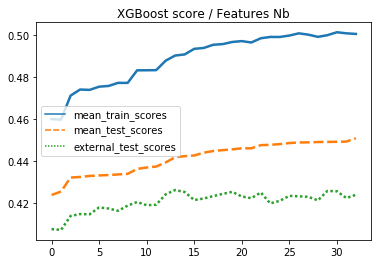

In [18]:
plot_scores(nb_feat_mean_train_scores, nb_feat_mean_test_scores, nb_feat_ext_test_scores, "XGBoost score / Features Nb")

In [19]:
# Get values between max and 5% less
print("Maximum gini score (on the external test CV) is reached for a feature number of : "+str( 2+nb_feat_mean_test_scores.index(max(nb_feat_mean_test_scores))))


Maximum gini score (on the external test CV) is reached for a feature number of : 34


We will keep these 26 features.

In [20]:
#optim_feat_nb = train_complete_df.shape[1]
final_feature_list

['superficief_expo',
 'Dep Moyenne Salaires Horaires',
 'all_risks_superficief',
 'superficief_bins_mean_target',
 'Nb Majeurs',
 'Nb institution de Education, santé, action sociale, administration',
 'Nb de Services aux particuliers',
 'EXPO_ft_24_categ_3',
 'EXPO_ft_7_categ_2',
 'Indice Ménages',
 'Reg Moyenne Salaires Prof Intermédiaire Horaires',
 'Insee_mean_target',
 'ft_14_categ_O',
 'EXPO_ft_21_categ_3',
 'categ_col_list_2_mean_target',
 'Hom_rate',
 'Dep Moyenne Salaires Employé Horaires',
 'Freq_TGN_1987_2015',
 'Fem_per_Hom',
 'all_risks_expo',
 'EXPO_ft_2_categ_2015',
 'EXPO_ft_2_categ_2012',
 'MSEH_DpR',
 'ft_4_categ_0',
 'EXPO_Bloc',
 'ft_24_categ_2',
 'EXPO_ft_23_categ_1.0',
 'ft_21_categ_4',
 'ft_24_categ_6',
 'ft_5_categ_N',
 'EXPO_ft_8_categ_N',
 'EXPO_ft_17_categ_V',
 'ft_19_categ_1',
 'Score Evasion Client',
 'ft_13_categ_V']

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  9.9min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc',
       eval_set=[(       EXPO  Is_EXPO_0  superficief_SUP_q975  ft_2_categ_2014  \
4      1.00          0                     0                0
9      1.00          0                     0                0
10     0.08          0                     0                0
13     1.00          0       ...   -1
10093   -1
10094   -1
10101   -1
10104   -1
10106   -1
10110   -1
Length: 2026, dtype: int64)],
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=9999999999, n_estimators=700, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.05, reg_lambda=0.1, scale_pos_weight=2, seed=None,
       silent=True, subsample=0.5)


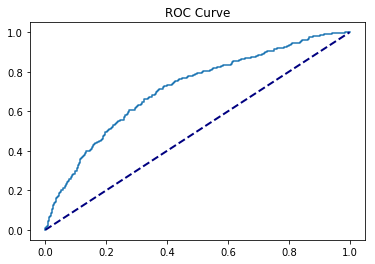

Confusion matrix, without normalization
[[1354  212]
 [ 278  182]]


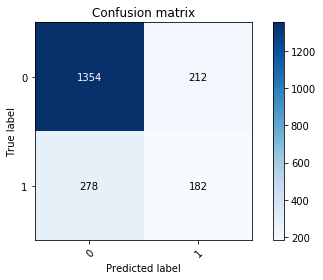

0.42383808095952036

In [21]:
# First hyperparameters exploration
from xgboost import plot_importance

def hyperparams_research(train, target):
    
    
    ##########################
    ## Part 1 : External Split
    ##########################
    nb_CV = 5
    CV = cross_validation_split(train, target, folds=nb_CV, target_signed=False) 
    
    # Internal CV evaluation
    cv_train_idx = list()
    cv_test_idx = list()
    train_score = list()
    test_score = list()
    
    # define train & test index
    cv_train_idx.append([ CV[x].index for x in range(nb_CV-1)])
    
    X_train = train_complete_df[train_complete_df.index.isin([val for sublist in cv_train_idx[0] for val in sublist])]
    y_train = target[target.index.isin([val for sublist in cv_train_idx[0] for val in sublist])]
    
    # Build the test dataset on a folder 
    cv_test_idx = CV[nb_CV-1].index
    X_test = train_complete_df[train_complete_df.index.isin(cv_test_idx)]
    y_test = target[target.index.isin(cv_test_idx)]   
    
    
    
    
    y_train_s = y_train.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    y_test_s = y_test.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    
    
    eval_set = [(X_test,y_test_s)]
    xgb_clf = xgb.XGBClassifier(booster='gbtree', missing=9999999999, 
                             eval_metric="auc", eval_set=eval_set, n_jobs=-1)

        
    params={
    'max_depth': [2], #[2, 3, 4, 5, 6],
    'subsample': [0.5],       # Boosting sample size
    'colsample_bytree': [ 0.6, 0.8 ], # Sample columns ratio by tree
    'colsample_bylevel' : [1],#[0.5, 1],
    'n_estimators': [ 700, 800, 900, 1000 ], #[400, 600, 800, 1000, 1200], 
    'scale_pos_weight' : [2], #[2, 3],
    'learning_rate' : [0.01], #[ 0.005, 0.01, 0.05],
    'reg_alpha' : [0.05],#[0.05, 0.1],
    'reg_lambda': [0.1, 0.5], #[0.01, 0.05, 0.1, 0.5, 1],
    'min_child_weight' : [1]#[0.2, 0.5, 1]
    }
    
    
    rs = GridSearchCV(xgb_clf,
                  params,
                  cv=3,
                  scoring="roc_auc",
                  n_jobs=-1, 
                  verbose=2,
                  return_train_score=True)
    rs.fit(X_train, y_train_s)
    best_est = rs.best_estimator_
    print(best_est)

    xgb_clf_pred_proba = rs.predict_proba(X_test)[:, 1]
    # Display ROC Curve
    fpr, tpr, _ = metrics.roc_curve(y_test.target, xgb_clf_pred_proba)
    plt.plot(fpr,tpr)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title("ROC Curve")
    plt.show()
    
    # Display confusion matrix
    analyze_model(xgb_clf_pred_proba, y_test.target)
    
    return gini_normalized(y_test.target, xgb_clf_pred_proba)



hyperparams_research(train_complete_df[final_feature_list], target)



# Evaluate model performance

In [22]:
xgb_clf1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc',
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=9999999999, n_estimators=700, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.05, reg_lambda=0.5, scale_pos_weight=2, seed=None,
       silent=True, subsample=0.5)
    
# Evaluate the model perf
std, mean_train, mean_test, ext_test_score, xg_trained, xg_feat_imp = double_split_train_test(xgb_clf1, train_complete_df[final_feature_list], target, outliers_idx, nb_CV = 5, print_scores=True)        


Train mean score: 0.5085362702196338
Test mean score : 0.4472104659696642
STD Test score: 0.037955031595771675
External Test score : 0.4168610139374757


In [39]:
from ngc_claims_functions import  *

def lm_threshold_perf(df, y):
    
    m_threshold = 0.5

    dfmax = df.target.max().round(2)
    dfmin = df.target.min().round(2)
    
    df["target_opt"] = 0
    df.loc[df["target"]> 0.8, "target_opt"] = 1
    df.loc[df["target"]< 0.2, "target_opt"]  = 0

    print(df.loc[0:10,"target"])
    print(gini_normalized(y, df["target"]))
    
    print(df.loc[0:10,"target_opt"])
    print(gini_normalized(y, df["target_opt"]))
    
    return df





nb_CV=5
CV = cross_validation_split(train_complete_df[final_feature_list], target, folds=nb_CV, target_signed=False) 
    
# Internal CV evaluation
cv_train_idx = list()
cv_test_idx = list()
train_score = list()
test_score = list()
    
# define train & test index
cv_train_idx.append([ CV[x].index for x in range(nb_CV-1)])
    
X_train = train_complete_df[train_complete_df.index.isin([val for sublist in cv_train_idx[0] for val in sublist])]
y_train = target[target.index.isin([val for sublist in cv_train_idx[0] for val in sublist])]
    
# Build the test dataset on a folder 
cv_test_idx = CV[nb_CV-1].index
X_test = train_complete_df[train_complete_df.index.isin(cv_test_idx)]
y_test = target[target.index.isin(cv_test_idx)] 
    
y_train_s = y_train.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
y_test_s = y_test.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
    
xgb_clf1 = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='auc',
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=9999999999, n_estimators=700, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.05, reg_lambda=0.5, scale_pos_weight=2, seed=None,
       silent=True, subsample=0.5)

xgb_clf1.fit(X_train[final_feature_list], y_train_s)
xgb_clf_pred_proba = xgb_clf1.predict_proba(X_test[final_feature_list])[:, 1]


lm_threshold_perf(pd.DataFrame({"target":xgb_clf_pred_proba}), y_test_s)



0    0.28
1    0.32
2    0.08
3    0.26
4    0.14
5    0.63
6    0.29
7    0.34
8    0.37
9    0.17
10   0.33
Name: target, dtype: float32
0.4168610139374757
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
Name: target_opt, dtype: int64
0.04888111499805645


,target,target_opt
0,0.28,0
1,0.32,0
2,0.08,0
3,0.26,0
4,0.14,0
5,0.63,0
6,0.29,0
7,0.34,0
8,0.37,0
9,0.17,0


# Prepare submission file

In [24]:
train_complete_df_bckp = train_complete_df.copy()
target_bckp = target.copy()

In [25]:
train_complete_df = train_complete_df_bckp.copy()
target = target_bckp.copy()

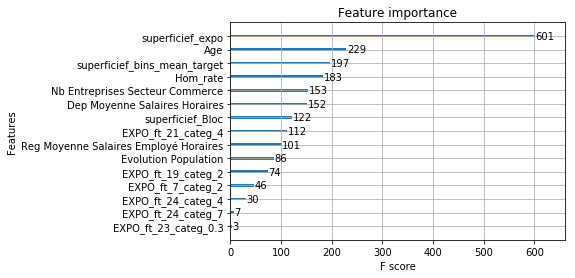

In [26]:
from xgboost import plot_importance

# Prepare target to train model
target.target = target.apply(lambda row: -1 if row['target']==0 else 1, axis=1)
target.drop(outliers_idx)

train_complete_df.drop(outliers_idx)

xgb_clf1.fit(train_complete_df[final_feature_list], target.target)

# Plot feature importance
plot_importance(xgb_clf1, max_num_features=30)
plt.show()


Features that we have brought from external data are kept by the model to predict our claim target.<br>
Some of them have been build by :
    - Interactions like all_risks_superficief, EXPO_ft_21_categ_4 or pop_rate_per_menage
    - Mean encoding like Insee_mean_target
    - Signal kept like Is_EXPO_0

But the main feature is superficief_expo and so even if we add information for our modelisation, we guess we won't change tremendously our performance for now.

In [27]:
# Predict and save result
model_pred = xgb_clf1.predict_proba(test_complete_df[final_feature_list])[:,1]
model_pred_df = pd.DataFrame({"order":test_index,"target":model_pred})
model_pred_df.to_csv("./test_with_Insee_submission.csv")

In [28]:
# Read the prediction done on test rows not having Insee data provided
without_Insee_submission = pd.read_csv("./test_without_Insee_submission.csv")
with_Insee_submission = pd.read_csv("./test_with_Insee_submission.csv")
del without_Insee_submission["Unnamed: 0"]
del with_Insee_submission["Unnamed: 0"]

In [29]:
# Build the submission file
df = pd.concat((with_Insee_submission,without_Insee_submission), axis=0)
df = df.sort_values("order",ascending=True)
df.reset_index(inplace=True)
pd.DataFrame({"target":df["target"]}).to_csv("./lma_submission.csv")

This submission provided a score at 0.4148 that is not so far from our external score estimation of 0.4209<br>
It almost match our test mean estimation of 0.45 with 0.03 standard deviation
We can figure out that our external imputation provide a bit of overfitting and could be fixed but it stays really close to the final estimation.<br>
After some submission we see that an improvement in our estimations is followed by more or less the same improvement in the public score on the data challenge.<br>

In [41]:
df["ratio"] = df["target"]/(1-df["target"])
df["ratio"] = df["ratio"]/df["ratio"].max()
df.loc[:, ["ratio", "target"]]
df.sort_values("target", ascending=False)

,index,order,target,ratio
3083,3045,"3,083.00",0.89,1.00
2473,2439,"2,473.00",0.89,0.94
313,311,313.00,0.86,0.72
2332,2303,"2,332.00",0.86,0.71
1033,1024,"1,033.00",0.85,0.68
518,515,518.00,0.85,0.66
1301,1288,"1,301.00",0.84,0.64
618,615,618.00,0.84,0.63
2277,2248,"2,277.00",0.84,0.62
1388,1375,"1,388.00",0.84,0.61
